# ARIMA+GARCH Trading Strategy on the S&P500 Stock 

If you've followed our past series on [time series analysis](https://github.com/Auquan/Tutorials#time-series-analysis), you're now all familiar with the powerful ARIMA and GARCH models to model financial series.

In this article, we will apply the previous knowledge in a practical example to develop a trading strategy for the S&P500 

## Strategy Overview

The idea of this strategy is as below:

* For each day, $n$, use differenced logarithmic returns of S&P 500 for the previous $k$ days to fit an optimal ARIMA and GARCH model
* Use the combined model to make a prediction for the next day returns
* If the prediction is positive, go long the stock and if negative, short the stock at $n_{th}$ day's close
* If the prediction is the same as the previous day then do nothing

In this sheet we will work with $k=500$, but this is parameter that can be optimised in order to improve performance or reduce drawdown.

**Note: The backtest is doesnot take comission or slippage into account, hence the performance achieved in a real trading system would be lower than what you see here.**

## Strategy Implementation

In [22]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [23]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2014/12/31'
endDateStr = '2017/12/31'
cachedFolderName = '/Users/dell/Auquan/auquantoolbox/yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1)).fillna(0)
lrets.index = pd.DatetimeIndex(lrets.index.values,freq=lrets.index.inferred_freq)


Reading SPX
Data ends before End Date. Filling rest of the data for SPX


In [24]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [25]:
windowLength = 252
foreLength = len(lrets) - windowLength

We also use [previously defined functions](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%204.ipynb) to find best ARIMA model

In [26]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1,4) # [1,2,3]
    for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,0,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, 0, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: %6.5f | order: %s'%(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



At this stage we need to loop through every day in the trading data and fit an appropriate ARIMA and GARCH model to the rolling window of length $k=500$. Given that we try 32 separate ARIMA fits and fit a GARCH model, for each day, the indicator can take a long time to generate.

In [27]:
signal = 0*lrets[-foreLength:]
for d in range(foreLength):
    # create a rolling window by selecting the values between 1+d and k+d of S&P500 returns
    TS = lrets[(1+d):(windowLength+d)] 
    # Find the best ARIMA fit (we set differencing to 0 since we've already differenced the series once)
    res_tup = _get_best_model(TS)
    order = res_tup[1]
    model = res_tup[2]
    #now that we have our ARIMA fit, we feed this to GARCH model
    p_ = order[0]
    o_ = order[1]
    q_ = order[2]

    am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    out = res.forecast(horizon=1, start=None, align='origin')
    signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

aic: 551.01397 | order: (2, 0, 1)
SPX    1.0
Name: 2014-12-31 00:00:00, dtype: float64
aic: 551.64280 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-02 00:00:00, dtype: float64
aic: 551.63314 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-05 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 557.53217 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-06 00:00:00, dtype: float64
aic: 558.25040 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-07 00:00:00, dtype: float64
aic: 561.43201 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 566.89153 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 567.92861 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-12 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 567.02172 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 564.62413 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-14 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 564.95571 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 565.90527 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 569.45704 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-20 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 569.05878 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 569.19146 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 571.32280 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-23 00:00:00, dtype: float64
aic: 565.31736 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-26 00:00:00, dtype: float64
aic: 565.00275 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 565.87534 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 567.91586 | order: (3, 0, 2)
SPX    1.0
Name: 2015-01-29 00:00:00, dtype: float64
aic: 568.40941 | order: (2, 0, 1)
SPX    1.0
Name: 2015-01-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 569.31876 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 561.25697 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-03 00:00:00, dtype: float64
aic: 566.67212 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-04 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 566.43169 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-05 00:00:00, dtype: float64
aic: 565.45785 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 560.23921 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-09 00:00:00, dtype: float64
aic: 563.47627 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-10 00:00:00, dtype: float64
aic: 563.44061 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-11 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.35372 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-12 00:00:00, dtype: float64
aic: 564.38589 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-13 00:00:00, dtype: float64
aic: 564.22298 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 560.21793 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-18 00:00:00, dtype: float64
aic: 563.46316 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-19 00:00:00, dtype: float64
aic: 562.87213 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-20 00:00:00, dtype: float64
aic: 563.50351 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-23 00:00:00, dtype: float64
aic: 558.52165 | order: (3, 0, 2)
SPX    1.0
Name: 2015-02-24 00:00:00, dtype: float64
aic: 562.87484 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-25 00:00:00, dtype: float64
aic: 562.88639 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-26 00:00:00, dtype: float64
aic: 562.43501 | order: (2, 0, 1)
SPX    1.0
Name: 2015-02-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 557.82592 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 558.41892 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-03 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 557.59824 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-04 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 558.32912 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-05 00:00:00, dtype: float64
aic: 558.65052 | order: (2, 0, 1)
SPX    1.0
Name: 2015-03-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 558.39159 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.05473 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-10 00:00:00, dtype: float64
aic: 567.25965 | order: (2, 0, 1)
SPX    1.0
Name: 2015-03-11 00:00:00, dtype: float64
aic: 567.34073 | order: (2, 0, 1)
SPX    1.0
Name: 2015-03-12 00:00:00, dtype: float64
aic: 567.29238 | order: (3, 0, 1)
SPX    1.0
Name: 2015-03-13 00:00:00, dtype: float64
aic: 567.45439 | order: (3, 0, 1)
SPX    1.0
Name: 2015-03-16 00:00:00, dtype: float64
aic: 567.54862 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-17 00:00:00, dtype: float64
aic: 567.11576 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-18 00:00:00, dtype: float64
aic: 569.31370 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-19 00:00:00, dtype: float64
aic: 569.68277 | order: (3, 0, 1)
SPX    1.0
Name: 2015-03-20 00:00:00, dtype: float64
aic: 570.44555 | order: (3, 0, 2)
SPX    1.0
Name: 2015-03-23 00:00:00, dtype: float64
aic: 570.59120 | order: (2, 0, 1)
SPX    1.0
Name: 2015-03-24 00:00:00, dtype: float64
aic: 570.00525 | order: (3, 0, 2)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 575.92681 | order: (3, 0, 2)
SPX    1.0
Name: 2015-04-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 575.41090 | order: (3, 0, 2)
SPX    1.0
Name: 2015-04-06 00:00:00, dtype: float64
aic: 571.20657 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-07 00:00:00, dtype: float64
aic: 569.78737 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-08 00:00:00, dtype: float64
aic: 568.75902 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 566.65832 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-10 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 558.88648 | order: (3, 0, 2)
SPX    1.0
Name: 2015-04-13 00:00:00, dtype: float64
aic: 557.72605 | order: (3, 0, 2)
SPX    1.0
Name: 2015-04-14 00:00:00, dtype: float64
aic: 558.33413 | order: (2, 0, 1)
SPX    1.0
Name: 2015-04-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 558.02202 | order: (2, 0, 1)
SPX    1.0
Name: 2015-04-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 550.63754 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 555.03955 | order: (3, 0, 2)
SPX    1.0
Name: 2015-04-20 00:00:00, dtype: float64
aic: 556.58028 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-21 00:00:00, dtype: float64
aic: 556.09662 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-22 00:00:00, dtype: float64
aic: 556.49042 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-23 00:00:00, dtype: float64
aic: 556.50003 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-24 00:00:00, dtype: float64
aic: 555.23777 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-27 00:00:00, dtype: float64
aic: 555.24097 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-28 00:00:00, dtype: float64
aic: 555.06988 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-29 00:00:00, dtype: float64
aic: 555.17430 | order: (2, 0, 2)
SPX    1.0
Name: 2015-04-30 00:00:00, dtype: float64
aic: 557.39267 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-01 00:00:00, dtype: float64
aic: 559.29399 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-04 00:00:00, dtype: float64
aic: 559.60535 | order: (2, 0, 2)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 563.24195 | order: (3, 0, 2)
SPX    1.0
Name: 2015-05-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 563.54738 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-11 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.18425 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-12 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.22488 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-13 00:00:00, dtype: float64
aic: 562.30778 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-14 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.42839 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.37212 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-18 00:00:00, dtype: float64
aic: 562.55500 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-19 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 563.61536 | order: (3, 0, 2)
SPX    1.0
Name: 2015-05-20 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 560.05522 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 559.94815 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 559.90466 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-26 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 561.25130 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.60939 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 561.67561 | order: (2, 0, 2)
SPX    1.0
Name: 2015-05-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.57734 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-01 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.58127 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.46894 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-03 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.55782 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-04 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.61087 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-05 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 562.24529 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 563.12631 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 563.11835 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-10 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 566.46883 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-11 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 566.20588 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-12 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 567.49489 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 568.00821 | order: (3, 0, 3)
SPX    1.0
Name: 2015-06-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 569.18046 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 568.53784 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-18 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 570.43441 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-19 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 572.29836 | order: (1, 0, 1)
SPX    1.0
Name: 2015-06-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 572.81013 | order: (3, 0, 2)
SPX    1.0
Name: 2015-06-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 570.60940 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-24 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 570.46778 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-25 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 570.52025 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-26 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 570.51216 | order: (2, 0, 2)
SPX    1.0
Name: 2015-06-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 578.85832 | order: (3, 0, 3)
SPX    1.0
Name: 2015-06-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 579.68711 | order: (2, 0, 2)
SPX    1.0
Name: 2015-07-01 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 580.87598 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 580.57046 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 580.30322 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-07 00:00:00, dtype: float64
aic: 580.11574 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 584.37268 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 583.70249 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-10 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 586.78951 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-13 00:00:00, dtype: float64
aic: 588.72595 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-14 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 587.80020 | order: (3, 0, 3)
SPX    1.0
Name: 2015-07-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 588.39216 | order: (3, 0, 3)
SPX    1.0
Name: 2015-07-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 587.09712 | order: (3, 0, 3)
SPX    1.0
Name: 2015-07-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 585.71619 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-20 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 584.95772 | order: (3, 0, 3)
SPX    1.0
Name: 2015-07-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 584.64479 | order: (3, 0, 3)
SPX    1.0
Name: 2015-07-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 585.61456 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 586.05700 | order: (3, 0, 3)
SPX    1.0
Name: 2015-07-24 00:00:00, dtype: float64
aic: 589.42511 | order: (3, 0, 2)
SPX    1.0
Name: 2015-07-27 00:00:00, dtype: float64
aic: 590.09862 | order: (3, 0, 2)
SPX    1.0
Name: 2015-07-28 00:00:00, dtype: float64
aic: 587.13488 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-29 00:00:00, dtype: float64
aic: 591.46273 | order: (1, 0, 1)
SPX    1.0
Name: 2015-07-30 00:00:00, dtype: float64
aic: 583.44602 | order: (2, 0, 2)
SPX    1.0
Name: 2015-07-31 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 583.41315 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-03 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 582.59646 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-04 00:00:00, dtype: float64
aic: 582.15311 | order: (1, 0, 1)
SPX    1.0
Name: 2015-08-05 00:00:00, dtype: float64
aic: 581.33040 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 583.49317 | order: (3, 0, 2)
SPX    1.0
Name: 2015-08-07 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 579.64943 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-10 00:00:00, dtype: float64
aic: 582.27233 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-11 00:00:00, dtype: float64
aic: 583.83258 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-12 00:00:00, dtype: float64
aic: 583.01331 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 582.78431 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-14 00:00:00, dtype: float64
aic: 583.11197 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-17 00:00:00, dtype: float64
aic: 582.45314 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-18 00:00:00, dtype: float64
aic: 582.16150 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-19 00:00:00, dtype: float64
aic: 583.44165 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-20 00:00:00, dtype: float64
aic: 591.00268 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-21 00:00:00, dtype: float64
aic: 610.07872 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-24 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 626.88590 | order: (2, 0, 2)
SPX    1.0
Name: 2015-08-25 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 629.88903 | order: (1, 0, 1)
SPX    1.0
Name: 2015-08-26 00:00:00, dtype: float64
aic: 651.05268 | order: (3, 0, 1)
SPX    1.0
Name: 2015-08-27 00:00:00, dtype: float64
aic: 652.28074 | order: (2, 0, 1)
SPX    1.0
Name: 2015-08-28 00:00:00, dtype: float64
aic: 652.80110 | order: (2, 0, 1)
SPX    1.0
Name: 2015-08-31 00:00:00, dtype: float64
aic: 654.39556 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-01 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 664.64787 | order: (3, 0, 2)
SPX    1.0
Name: 2015-09-02 00:00:00, dtype: float64
aic: 670.98808 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-03 00:00:00, dtype: float64
aic: 671.03915 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-04 00:00:00, dtype: float64
aic: 674.57295 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-08 00:00:00, dtype: float64
aic: 680.89350 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-09 00:00:00, dtype: float64
aic: 684.97540 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-10 00:00:00, dtype: float64
aic: 685.23189 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-11 00:00:00, dtype: float64
aic: 684.83109 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-14 00:00:00, dtype: float64
aic: 685.19955 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 686.25799 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 686.68620 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-17 00:00:00, dtype: float64
aic: 686.71459 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-18 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 689.72266 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-21 00:00:00, dtype: float64
aic: 689.24013 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-22 00:00:00, dtype: float64
aic: 690.63220 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-23 00:00:00, dtype: float64
aic: 689.91447 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-24 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 686.36125 | order: (2, 0, 2)
SPX    1.0
Name: 2015-09-25 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 685.79335 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-28 00:00:00, dtype: float64
aic: 693.63331 | order: (2, 0, 2)
SPX    1.0
Name: 2015-09-29 00:00:00, dtype: float64
aic: 694.00583 | order: (2, 0, 1)
SPX    1.0
Name: 2015-09-30 00:00:00, dtype: float64
aic: 694.66941 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-01 00:00:00, dtype: float64
aic: 694.65490 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-02 00:00:00, dtype: float64
aic: 694.19469 | order: (2, 0, 2)
SPX    1.0
Name: 2015-10-05 00:00:00, dtype: float64
aic: 698.50045 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-06 00:00:00, dtype: float64
aic: 694.92103 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-07 00:00:00, dtype: float64
aic: 692.08573 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-08 00:00:00, dtype: float64
aic: 689.18062 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-09 00:00:00, dtype: float64
aic: 689.67934 | order: (1, 0, 1)
SPX    1.0
Name: 2015-10-12 00:00:00, dtype: float64
aic: 686.24461 | order: (2, 0, 1)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 681.07805 | order: (2, 0, 2)
SPX    1.0
Name: 2015-10-26 00:00:00, dtype: float64
aic: 681.06610 | order: (2, 0, 2)
SPX    1.0
Name: 2015-10-27 00:00:00, dtype: float64
aic: 678.73299 | order: (2, 0, 1)
SPX    1.0
Name: 2015-10-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 680.85926 | order: (2, 0, 2)
SPX    1.0
Name: 2015-10-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 680.35069 | order: (2, 0, 2)
SPX    1.0
Name: 2015-10-30 00:00:00, dtype: float64
aic: 678.95609 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-02 00:00:00, dtype: float64
aic: 681.35128 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-03 00:00:00, dtype: float64
aic: 681.38296 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-04 00:00:00, dtype: float64
aic: 680.99708 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-05 00:00:00, dtype: float64
aic: 682.35282 | order: (2, 0, 2)
SPX    1.0
Name: 2015-11-06 00:00:00, dtype: float64
aic: 680.79929 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-09 00:00:00, dtype: float64
aic: 681.55432 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-10 00:00:00, dtype: float64
aic: 681.65285 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-11 00:00:00, dtype: float64
aic: 681.80377 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-12 00:00:00, dtype: float64
aic: 683.98965 | order: (2, 0, 1)
SPX    1.0
Name: 2015-11-13 00:00:00, dtype: float64
aic: 685.17828 | order: (2, 0, 1)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 698.79685 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-07 00:00:00, dtype: float64
aic: 699.00927 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-08 00:00:00, dtype: float64
aic: 699.32215 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 696.78161 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-10 00:00:00, dtype: float64
aic: 696.23802 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-11 00:00:00, dtype: float64
aic: 698.81172 | order: (2, 0, 2)
SPX    1.0
Name: 2015-12-14 00:00:00, dtype: float64
aic: 699.17234 | order: (2, 0, 2)
SPX    1.0
Name: 2015-12-15 00:00:00, dtype: float64
aic: 699.21991 | order: (2, 0, 2)
SPX    1.0
Name: 2015-12-16 00:00:00, dtype: float64
aic: 697.13239 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-17 00:00:00, dtype: float64
aic: 693.96952 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-18 00:00:00, dtype: float64
aic: 696.61315 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 697.20325 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 697.57528 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 698.81032 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-24 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 698.84653 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-28 00:00:00, dtype: float64
aic: 698.82551 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-29 00:00:00, dtype: float64
aic: 699.92497 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-30 00:00:00, dtype: float64
aic: 698.79231 | order: (2, 0, 1)
SPX    1.0
Name: 2015-12-31 00:00:00, dtype: float64
aic: 699.37289 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-04 00:00:00, dtype: float64
aic: 698.83644 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-05 00:00:00, dtype: float64
aic: 698.02657 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-06 00:00:00, dtype: float64
aic: 699.82549 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-07 00:00:00, dtype: float64
aic: 703.40126 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-08 00:00:00, dtype: float64
aic: 704.20297 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-11 00:00:00, dtype: float64
aic: 703.60255 | order: (2, 0, 1)
SPX    1.0
Name: 2016-01-12 00:00:00, dtype: float64
aic: 703.69952 | order: (2, 0, 1)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 745.31662 | order: (2, 0, 2)
SPX    1.0
Name: 2016-03-07 00:00:00, dtype: float64
aic: 746.15430 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 744.76405 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-09 00:00:00, dtype: float64
aic: 744.01417 | order: (2, 0, 2)
SPX    1.0
Name: 2016-03-10 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 743.39568 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-11 00:00:00, dtype: float64
aic: 744.92227 | order: (2, 0, 2)
SPX    1.0
Name: 2016-03-14 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 743.74353 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-15 00:00:00, dtype: float64
aic: 743.59549 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-16 00:00:00, dtype: float64
aic: 742.60771 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-17 00:00:00, dtype: float64
aic: 742.68497 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-18 00:00:00, dtype: float64
aic: 742.33801 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-21 00:00:00, dtype: float64
aic: 742.30621 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-22 00:00:00, dtype: float64
aic: 742.03185 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-23 00:00:00, dtype: float64
aic: 740.51802 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-24 00:00:00, dtype: float64
aic: 740.48527 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-28 00:00:00, dtype: float64
aic: 740.46886 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 739.67615 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-30 00:00:00, dtype: float64
aic: 739.22835 | order: (2, 0, 1)
SPX    1.0
Name: 2016-03-31 00:00:00, dtype: float64
aic: 739.13993 | order: (2, 0, 1)
SPX    1.0
Name: 2016-04-01 00:00:00, dtype: float64
aic: 739.49750 | order: (2, 0, 1)
SPX    1.0
Name: 2016-04-04 00:00:00, dtype: float64
aic: 739.10575 | order: (2, 0, 1)
SPX    1.0
Name: 2016-04-05 00:00:00, dtype: float64
aic: 739.88124 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-06 00:00:00, dtype: float64
aic: 740.63903 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-07 00:00:00, dtype: float64
aic: 741.94133 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-08 00:00:00, dtype: float64
aic: 742.15903 | order: (2, 0, 1)
SPX    1.0
Name: 2016-04-11 00:00:00, dtype: float64
aic: 741.44867 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-12 00:00:00, dtype: float64
aic: 742.38310 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 742.97466 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-14 00:00:00, dtype: float64
aic: 742.98659 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-15 00:00:00, dtype: float64
aic: 741.28672 | order: (3, 0, 2)
SPX    1.0
Name: 2016-04-18 00:00:00, dtype: float64
aic: 740.75657 | order: (3, 0, 2)
SPX    1.0
Name: 2016-04-19 00:00:00, dtype: float64
aic: 740.62487 | order: (3, 0, 2)
SPX    1.0
Name: 2016-04-20 00:00:00, dtype: float64
aic: 740.30990 | order: (3, 0, 2)
SPX    1.0
Name: 2016-04-21 00:00:00, dtype: float64
aic: 738.67567 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-22 00:00:00, dtype: float64
aic: 738.59456 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-25 00:00:00, dtype: float64
aic: 738.15192 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-26 00:00:00, dtype: float64
aic: 738.15806 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-27 00:00:00, dtype: float64
aic: 737.78063 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 737.58737 | order: (2, 0, 2)
SPX    1.0
Name: 2016-04-29 00:00:00, dtype: float64
aic: 737.38159 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 737.96152 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-03 00:00:00, dtype: float64
aic: 736.75613 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-04 00:00:00, dtype: float64
aic: 736.80433 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-05 00:00:00, dtype: float64
aic: 736.82506 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-06 00:00:00, dtype: float64
aic: 735.20685 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-09 00:00:00, dtype: float64
aic: 734.65406 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-10 00:00:00, dtype: float64
aic: 736.61298 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-11 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 737.75214 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-12 00:00:00, dtype: float64
aic: 736.83411 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 737.82936 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-16 00:00:00, dtype: float64
aic: 739.47201 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-17 00:00:00, dtype: float64
aic: 742.37770 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-18 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 742.47406 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-19 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 741.34721 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-20 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 741.94161 | order: (2, 0, 1)
SPX    1.0
Name: 2016-05-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 741.99422 | order: (2, 0, 1)
SPX    1.0
Name: 2016-05-24 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 743.01342 | order: (2, 0, 1)
SPX    1.0
Name: 2016-05-25 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 743.10911 | order: (2, 0, 2)
SPX    1.0
Name: 2016-05-26 00:00:00, dtype: float64
aic: 742.97488 | order: (2, 0, 1)
SPX    1.0
Name: 2016-05-27 00:00:00, dtype: float64
aic: 743.19840 | order: (2, 0, 1)
SPX    1.0
Name: 2016-05-31 00:00:00, dtype: float64
aic: 743.17479 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-01 00:00:00, dtype: float64
aic: 743.16239 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 742.57877 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-03 00:00:00, dtype: float64
aic: 742.63312 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-06 00:00:00, dtype: float64
aic: 742.58780 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-07 00:00:00, dtype: float64
aic: 742.60416 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-08 00:00:00, dtype: float64
aic: 741.48828 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-09 00:00:00, dtype: float64
aic: 741.46746 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-10 00:00:00, dtype: float64
aic: 741.79156 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-13 00:00:00, dtype: float64
aic: 742.08247 | order: (2, 0, 2)
SPX    1.0
Name: 2016-06-14 00:00:00, dtype: float64
aic: 740.19606 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-15 00:00:00, dtype: float64
aic: 741.44433 | order: (2, 0, 2)
SPX    1.0
Name: 2016-06-16 00:00:00, dtype: float64
aic: 741.06029 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-17 00:00:00, dtype: float64
aic: 740.85266 | order: (2, 0, 1)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 741.55218 | order: (2, 0, 2)
SPX    1.0
Name: 2016-06-24 00:00:00, dtype: float64
aic: 754.08016 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 750.92196 | order: (2, 0, 2)
SPX    1.0
Name: 2016-06-28 00:00:00, dtype: float64
aic: 754.98270 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-29 00:00:00, dtype: float64
aic: 756.16380 | order: (2, 0, 1)
SPX    1.0
Name: 2016-06-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 757.44538 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-01 00:00:00, dtype: float64
aic: 757.32089 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-05 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 756.94053 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 755.43013 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-07 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 755.36055 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-08 00:00:00, dtype: float64
aic: 755.64189 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-11 00:00:00, dtype: float64
aic: 755.25554 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-12 00:00:00, dtype: float64
aic: 755.64425 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 755.63882 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-14 00:00:00, dtype: float64
aic: 755.53340 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 755.53352 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-18 00:00:00, dtype: float64
aic: 755.63227 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-19 00:00:00, dtype: float64
aic: 755.42318 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-20 00:00:00, dtype: float64
aic: 755.56096 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-21 00:00:00, dtype: float64
aic: 755.46083 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-22 00:00:00, dtype: float64
aic: 754.92953 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-25 00:00:00, dtype: float64
aic: 754.71262 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-26 00:00:00, dtype: float64
aic: 753.50594 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-27 00:00:00, dtype: float64
aic: 753.10124 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-28 00:00:00, dtype: float64
aic: 753.12541 | order: (2, 0, 1)
SPX    1.0
Name: 2016-07-29 00:00:00, dtype: float64
aic: 753.09426 | order: (2, 0, 1)
SPX    1.0
Name: 2016-08-01 00:00:00, dtype: float64
aic: 753.03940 | order: (2, 0, 1)
SPX    1.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 751.23856 | order: (2, 0, 1)
SPX    1.0
Name: 2016-08-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 751.14583 | order: (2, 0, 1)
SPX    1.0
Name: 2016-08-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 747.61897 | order: (3, 0, 2)
SPX    1.0
Name: 2016-08-18 00:00:00, dtype: float64
aic: 742.03934 | order: (3, 0, 2)
SPX    1.0
Name: 2016-08-19 00:00:00, dtype: float64
aic: 734.81332 | order: (2, 0, 1)
SPX    1.0
Name: 2016-08-22 00:00:00, dtype: float64
aic: 722.01676 | order: (1, 0, 2)
SPX    1.0
Name: 2016-08-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 720.12357 | order: (3, 0, 3)
SPX    1.0
Name: 2016-08-24 00:00:00, dtype: float64
aic: 703.55057 | order: (1, 0, 1)
SPX    1.0
Name: 2016-08-25 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 697.66064 | order: (1, 0, 1)
SPX    1.0
Name: 2016-08-26 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 697.68945 | order: (1, 0, 1)
SPX    1.0
Name: 2016-08-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 695.47211 | order: (3, 0, 2)
SPX    1.0
Name: 2016-08-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 687.51552 | order: (3, 0, 3)
SPX    1.0
Name: 2016-08-31 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 678.86006 | order: (2, 0, 2)
SPX    1.0
Name: 2016-09-01 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 683.47511 | order: (3, 0, 3)
SPX    1.0
Name: 2016-09-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 680.84362 | order: (3, 0, 3)
SPX    1.0
Name: 2016-09-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 664.22332 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-07 00:00:00, dtype: float64
aic: 674.76693 | order: (2, 0, 1)
SPX    1.0
Name: 2016-09-08 00:00:00, dtype: float64
aic: 661.28064 | order: (2, 0, 2)
SPX    1.0
Name: 2016-09-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 669.32943 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-12 00:00:00, dtype: float64
aic: 683.49625 | order: (2, 0, 1)
SPX    1.0
Name: 2016-09-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 674.56426 | order: (2, 0, 2)
SPX    1.0
Name: 2016-09-14 00:00:00, dtype: float64
aic: 681.60478 | order: (1, 0, 1)
SPX    1.0
Name: 2016-09-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 675.72913 | order: (2, 0, 2)
SPX    1.0
Name: 2016-09-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 679.59441 | order: (1, 0, 1)
SPX    1.0
Name: 2016-09-19 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 671.76207 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-20 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 671.14839 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 672.62943 | order: (2, 0, 2)
SPX    1.0
Name: 2016-09-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 672.16355 | order: (2, 0, 2)
SPX    1.0
Name: 2016-09-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 671.43489 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-26 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 672.80917 | order: (3, 0, 3)
SPX    1.0
Name: 2016-09-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 666.60875 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 667.19113 | order: (3, 0, 2)
SPX    1.0
Name: 2016-09-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 669.68530 | order: (1, 0, 1)
SPX    1.0
Name: 2016-09-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 667.27798 | order: (1, 0, 1)
SPX    1.0
Name: 2016-10-03 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 657.74538 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-04 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 662.63453 | order: (2, 0, 2)
SPX    1.0
Name: 2016-10-05 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 656.99877 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 656.44279 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-07 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 656.46596 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-10 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 661.41653 | order: (2, 0, 2)
SPX    1.0
Name: 2016-10-11 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 658.35335 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-12 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 658.13801 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-13 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 651.33976 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-14 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 660.26110 | order: (1, 0, 1)
SPX    1.0
Name: 2016-10-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 651.44252 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-18 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 652.24380 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-19 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 652.02357 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-20 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 656.79366 | order: (1, 0, 1)
SPX    1.0
Name: 2016-10-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 647.58567 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-24 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 647.78990 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-25 00:00:00, dtype: float64
aic: 647.93520 | order: (3, 0, 2)
SPX    1.0
Name: 2016-10-26 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 653.93469 | order: (1, 0, 1)
SPX    1.0
Name: 2016-10-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 654.06926 | order: (1, 0, 1)
SPX    1.0
Name: 2016-10-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 654.06742 | order: (1, 0, 1)
SPX    1.0
Name: 2016-10-31 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 644.56794 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-01 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 644.32738 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-02 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 645.77721 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-03 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 646.03497 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-04 00:00:00, dtype: float64
aic: 646.06837 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-07 00:00:00, dtype: float64
aic: 658.28967 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 648.71639 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-09 00:00:00, dtype: float64
aic: 660.30587 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-10 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 657.78141 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-11 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 647.19626 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-14 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 644.72555 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-15 00:00:00, dtype: float64
aic: 654.33285 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 642.99069 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-17 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 651.28704 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-18 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 651.15308 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 651.84922 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 643.07670 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-23 00:00:00, dtype: float64
aic: 643.12408 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-25 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 643.15385 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 643.06347 | order: (3, 0, 2)
SPX    1.0
Name: 2016-11-29 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 651.12572 | order: (1, 0, 1)
SPX    1.0
Name: 2016-11-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 640.30608 | order: (3, 0, 2)
SPX    1.0
Name: 2016-12-01 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 638.51915 | order: (3, 0, 2)
SPX    1.0
Name: 2016-12-02 00:00:00, dtype: float64
aic: 642.02152 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-05 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 633.66554 | order: (3, 0, 2)
SPX    1.0
Name: 2016-12-06 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 640.50554 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-07 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 632.32952 | order: (3, 0, 2)
SPX    1.0
Name: 2016-12-08 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 639.59833 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-09 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 634.66444 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-12 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 628.64720 | order: (3, 0, 2)
SPX    1.0
Name: 2016-12-13 00:00:00, dtype: float64
aic: 632.43146 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-14 00:00:00, dtype: float64
aic: 629.99778 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-15 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 626.07216 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-16 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: 621.66015 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-19 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 620.24679 | order: (2, 0, 2)
SPX    1.0
Name: 2016-12-20 00:00:00, dtype: float64
aic: 619.20941 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-21 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: 616.97989 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-22 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: 616.92506 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-23 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: 616.90380 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-26 00:00:00, dtype: float64
aic: 615.38558 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-27 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: 613.75770 | order: (2, 0, 2)
SPX    1.0
Name: 2016-12-28 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: 612.64605 | order: (1, 0, 1)
SPX    1.0
Name: 2016-12-29 00:00:00, dtype: float64
aic: 609.10827 | order: (1, 0, 1)
SPX   -1.0
Name: 2016-12-30 00:00:00, dtype: float64


C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\arch\univariate\base.py:513: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


## Strategy Results

Now that we have generated our signals, we need to compare its performance to "Buy & Hold".


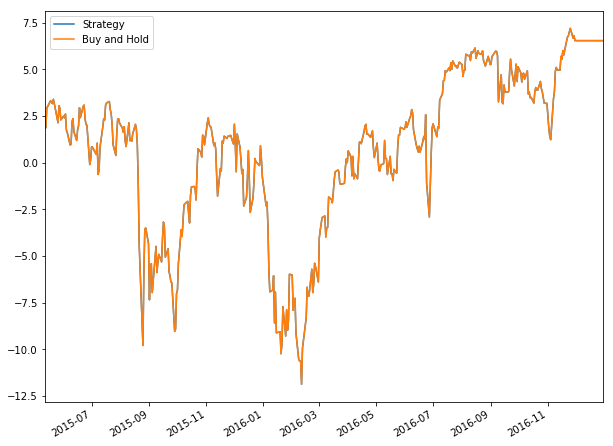

In [28]:
rets = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
rets['Buy and Hold'] = lrets[-foreLength:]
rets['Strategy'] = signal
rets['Strategy'] = rets['Strategy']*rets['Buy and Hold']
eqCurves['Buy and Hold']=rets['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = rets['Strategy'].cumsum()+1
eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()